In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size,200)] + [nn.Linear(200,200) for i in range(25)])
        self.p_layer = nn.Linear(200,1)
        self.n_layer = nn.Linear(200,1)
        torch.nn.init.orthogonal_(self.p_layer.weight)
        torch.nn.init.zeros_(self.p_layer.bias)
        torch.nn.init.orthogonal_(self.n_layer.weight)
        # torch.nn.init.zeros_(self.n_layer.bias)


    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = F.hardtanh(x) + x
        p = torch.sigmoid(self.p_layer(x))
        n = torch.exp(self.n_layer(x))
        return torch.cat((p*n,(1-p)*n),axis=-1)

In [3]:
torch.FloatTensor([1]).mean()

tensor(1.)

In [24]:
def log_likelihood_loss(alpha, beta, target_alpha, target_beta):
    # print(alpha)
    # print(beta)
    # print(target_alpha)
    # print(target_beta)
    return -(
        (alpha-1)*(torch.digamma(target_alpha)-torch.digamma(target_alpha+target_beta)) + 
        (beta-1) *(torch.digamma(target_beta) -torch.digamma(target_alpha+target_beta)) -
        torch.lgamma(alpha)-torch.lgamma(beta)+torch.lgamma(alpha+beta)).mean()

In [14]:
def reverse_log_likelihood_loss(alpha, beta, target_alpha, target_beta):
    return -(
        (target_alpha-1)*(torch.digamma(alpha)-torch.digamma(alpha+beta)) + 
        (target_beta-1) *(torch.digamma(beta) -torch.digamma(alpha+beta))
        -torch.lgamma(target_alpha)-torch.lgamma(target_beta)+torch.lgamma(target_alpha+target_beta)).mean()
        # ).mean()

In [6]:
def cross_entropy_loss(alpha, beta, target_alpha, target_beta):
    return -(target_alpha*(torch.digamma(alpha)-torch.digamma(alpha+beta)) + target_beta*(torch.digamma(beta)-torch.digamma(alpha+beta))).mean()

In [49]:
input_size = 20
network = Net(input_size)

In [50]:
optimizer = torch.optim.SGD(network.parameters(), lr=1e-5)
batch_size = 1
p=.5
running_loss = 0
running_evidence = 0
bayes_risk_loss = 0
gamma = .999
while True:
    optimizer.zero_grad()
    inpt = torch.bernoulli(torch.ones(batch_size,input_size)*p)
    # print(inpt)
    out = network(inpt)
    alpha, beta = out[:,:1], out[:,1:]
    # print(alpha)
    # print(beta)
    # print(out)
    # print(inpt.mean(axis=1))
    target = torch.bernoulli(torch.ones(batch_size)*inpt.mean(axis=1))
    # print(target)
    # print(target*alpha/(alpha+beta)*(torch.digamma(alpha+1)-torch.digamma(alpha + beta + 1)))
    # print((1-target)*beta/(alpha+beta)*(torch.digamma(beta+1)-torch.digamma(alpha + beta + 1)))
    # loss = -(target*alpha/(alpha+beta)*(torch.digamma(alpha+1)-torch.digamma(alpha + beta + 1)) + (1-target)*beta/(alpha+beta)*(torch.digamma(beta+1)-torch.digamma(alpha + beta + 1)))
    # loss = log_likelihood_loss(alpha, beta, target+1, 1-target+1)
    loss = log_likelihood_loss(alpha, beta, alpha.detach()+target, beta.detach() + 1-target)
    # loss = reverse_log_likelihood_loss(alpha, beta, target+1, 1-target+1)
    # loss = cross_entropy_loss(alpha, beta, target+1, 1-target+1)
    # print('loss')
    running_loss = running_loss *gamma +loss*(1-gamma)
    running_evidence = running_evidence*gamma +(alpha+beta).mean()*(1-gamma)
    bayes_risk_loss = bayes_risk_loss *gamma +log_likelihood_loss(alpha, beta, target+1, (1-target)+1)*(1-gamma)
    print(f'running loss:{running_loss}')
    print(f'bayes risk loss:{bayes_risk_loss}')
    print(f'running evidence:{running_evidence}')
    # print(torch.exp(-loss))
    loss.backward()
    optimizer.step()

running loss:-0.007501068525016308
bayes risk loss:0.002002744935452938
running evidence:0.00010990319424308836
running loss:-0.01005596574395895
bayes risk loss:0.004300842061638832
running evidence:0.000263337220530957
running loss:-0.03577900677919388
bayes risk loss:0.00807890109717846
running evidence:0.00029753701528534293
running loss:-0.30331289768218994
bayes risk loss:0.01177448034286499
running evidence:0.0003751964250113815
running loss:-0.31466999650001526
bayes risk loss:0.01355607621371746
running evidence:0.00047895743045955896
running loss:-0.3209702670574188
bayes risk loss:0.01850477047264576
running evidence:0.0005491746705956757
running loss:-0.3338429927825928
bayes risk loss:0.02051938883960247
running evidence:0.0006342161213979125
running loss:-0.9466293454170227
bayes risk loss:0.024989578872919083
running evidence:0.0007067173719406128
running loss:-0.9474837779998779
bayes risk loss:0.02533985674381256
running evidence:0.0013114092871546745
running loss:-0.9

KeyboardInterrupt: 

In [ ]:
torch.bernoulli(torch.ones(batch_size)*inpt.mean(axis=1))

tensor([1.])

In [ ]:
inpt.mean(axis=1)

2000

In [ ]:
inpt.mean(axis=1)

tensor([0.2000, 0.4000])

In [ ]:
inpt = torch.bernoulli(torch.ones(1,input_size)*p)
print(inpt)
print(inpt.mean())
out = network(inpt)
print(out)
print(out[0,0]/out.sum())

tensor([[1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
         1., 0.]])
tensor(0.5500)
tensor([[0.6451, 0.6934]], grad_fn=<CatBackward0>)
tensor(0.4820, grad_fn=<DivBackward0>)


In [ ]:
out[0,0]/out.sum()

tensor(0.6323, grad_fn=<DivBackward0>)

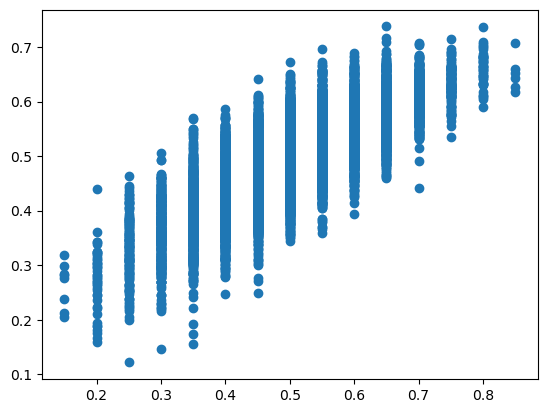

In [51]:
means = []
p_hats = []
evidences = []
for i in range(10000):
    inpt = torch.bernoulli(torch.ones(1,input_size)*p)
    out = network(inpt)
    means.append(inpt.mean().item())
    p_hats.append((out[0,0]/out.sum()).item())
    evidences.append(out.sum().item())
plt.scatter(means, p_hats)

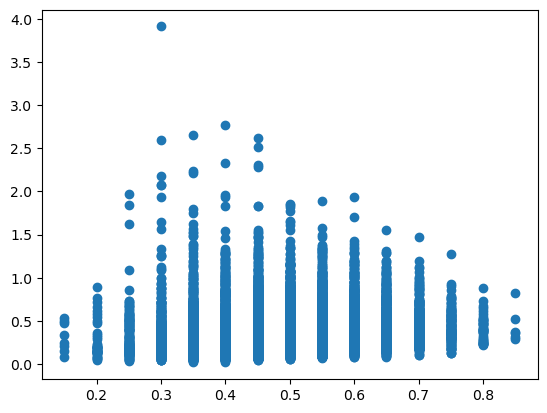

In [52]:
plt.scatter(means, evidences)

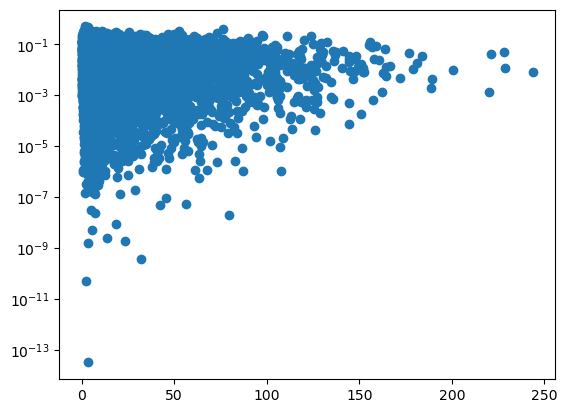

In [19]:
plt.yscale('log')
plt.scatter(np.array(evidences),(np.array(means)-np.array(p_hats))**2)